<img src='../OUTILS/bandeau_MF.png' align='right' width='100%'/>

<div class="alert alert-info alert-success">
<h3>Elaboration de la RGB Cloud Type - FCI /MTG </h3></div>

## <a id='TOC-TOP'></a>Contenus

<div class="alert alert-block alert-warning">
    
<b>PREREQUIS </b>
    
Ce Notebook ne nécessite pas de prérequis 

</div>
<hr>

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1.Tout d'abord, il faut procéder à l'importation des librairies nécessaires.

</div>

In [ ]:
from PIL import Image
from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import subprocess

### Données d'entrée : fichier multicanaux mtg

In [ ]:
download_dir = os.path.join(os.getcwd(), "../RESULTATS")
os.makedirs(download_dir, exist_ok=True)

In [ ]:
input = '../../MF_DATA/MTG/MTG_multic/Multic2km_mtgi1_20231122_140000.nc'

In [ ]:
input

In [ ]:
pwd

### Définition du dossier de sortie :

In [ ]:
download_dir = os.path.join(os.getcwd(), "../RESULTATS")
os.makedirs(download_dir, exist_ok=True)

In [ ]:
output = '../RESULTATS'

In [ ]:
output

In [ ]:
#!gdalinfo $input

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2.Extraction des données dans le NetCDF
[Back to top](#TOC-TOP)

</div>


Pour rappel, la recette de la RGB cloud type est la suivante :

<img src='../OUTILS/cloudtype_tableau.png' align='right' width='100%'/>

Red: NIR1.38, range 0 to 10 %, Gamma = 1.5

Green: VIS0.67, Range 0 to 80 %, Gamma = 0.75

Blue: VIS1.61, range 0 to 80 %, Gamma = 1

Extraction des données des trois longueurs d'ondes nécessaires aux calculs des différences :

In [ ]:
!gdal_translate NETCDF:"$input":IR_013 {output}/013.tif
!gdal_translate NETCDF:"$input":VIS006 {output}/006.tif
!gdal_translate NETCDF:"$input":IR_016 {output}/016.tif

Extraction des données IR_013 pour la bande rouge.
Les valeurs 0 et 10 % 


In [ ]:
!gdal_translate -ot byte -scale 0 1000 0 255 NETCDF:"$input":IR_013 {output}/013_scale.tif

Extraction des données VIS006 pour la bande verte.
Les valeurs 0 et 80 % 
Extraction des données IR 1.6 pour la bande bleue.Les valeurs 0 et 80 % 



In [ ]:
!gdal_translate -ot byte -scale 0 8000 0 255 NETCDF:"$input":VIS006 {output}/006_scale.tif
!gdal_translate -ot byte -scale 0 8000 0 255 NETCDF:"$input":IR_016 {output}/016_scale.tif

### Calcul de la correction gamma avec gdal_calc.py :

Pour rappel la formule de la correction gamme est :

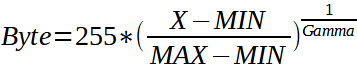


(Note : imagemagick permet de faire une correction gamma mais n'est pas compatible avec Windows)

La première étape consiste à extraire les valeurs min et max de l'image.

In [ ]:
file_in = '../RESULTATS/013_scale.tif'
imgpil = Image.open(file_in)  
img = np.array(imgpil)
max = np.max(img)
min = np.min(img)

Ensuite on calcule et on applique la correction gamma pour une valeur de 1.5 :

In [ ]:
gamma= 1.5

In [ ]:
!gdal_calc.py --quiet --NoDataValue 0 --overwrite -A {file_in} --calc="numpy.maximum(A*0.,{max}*((A-{min}.)/({max}-{min}))**(1/{gamma}))" --outfile {output}/013_scale_gamma.tif

In [ ]:
file_in = '../RESULTATS/006_scale.tif'
imgpil = Image.open(file_in)  
img = np.array(imgpil)
max = np.max(img)
min = np.min(img)

In [ ]:
gamma= 0.75

In [ ]:
!gdal_calc.py --quiet --NoDataValue 0 --overwrite -A {file_in} --calc="numpy.maximum(A*0.,{max}*((A-{min}.)/({max}-{min}))**(1/{gamma}))" --outfile {output}/006_scale_gamma.tif

In [ ]:
file_in = '../RESULTATS/016_scale.tif'
imgpil = Image.open(file_in)  
img = np.array(imgpil)
max = np.max(img)
min = np.min(img)

In [ ]:
gamma= 1

In [ ]:
!gdal_calc.py --quiet --NoDataValue 0 --overwrite -A {file_in} --calc="numpy.maximum(A*0.,{max}*((A-{min}.)/({max}-{min}))**(1/{gamma}))" --outfile {output}/016_scale_gamma.tif

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3.Fabrication de la RGB
[Back to top](#TOC-TOP)

</div>

(la commande gdal_merge.py n'écrase pas en sortie c'est pourquoi un rm est fait pour supprimer une image qui aurait été créée précédemment)

In [ ]:
!gdal_merge.py -separate {output}/013_scale_gamma.tif {output}/006_scale_gamma.tif {output}/016_scale_gamma.tif -o {output}/RGB_cloudtype.tif

### Création et affichage d'une image redimmensionnée

In [ ]:
!convert -resize 500x500 {output}/RGB_cloudtype.tif {output}/RGB_cloudtype_min.jpg

### Visualisation du résultat

In [ ]:
im = Image.open(output + '/RGB_cloudtype_min.jpg', 'r')
display(im)

### Définition de la zone du zoom

In [ ]:
N=40
S=15
O=-23
E=8

In [ ]:
!gdalinfo {output}/RGB_cloudtype.tif

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4.Découpes et reprojections
[Back to top](#TOC-TOP)

</div>

## WGS 84 (World Geodetic System 1984): EPSG: 4326 Un système de coordonnées géographiques utilisé pour le GPS et d'autres applications géospatiales. 

In [ ]:
!gdalwarp -t_srs "EPSG:4326" -te -23 15 8 40 -overwrite {output}/RGB_cloudtype.tif {output}/RGB_cloudtype_zoom.tif

### Création et affichage d'une image zoomée redimmensionnée

In [ ]:
!convert -resize 500x500 {output}/RGB_cloudtype_zoom.tif {output}/RGB_cloudtype_zoom_min.jpg

In [ ]:
im2 = Image.open(output + '/RGB_cloudtype_zoom_min.jpg', 'r')
display(im2)

## Utilisation de la projection orthographique

In [ ]:
!gdalwarp -t_srs "+proj=ortho lat_0=30 lon_0=-8" {output}/RGB_cloudtype_zoom.tif {output}/RGB_cloudtype_zoom_ortho.tif

In [ ]:
!convert -resize 500x500 {output}/RGB_cloudtype_zoom_ortho.tif {output}/RGB_cloudtype_zoom_ortho_min.jpg

In [ ]:
im3 = Image.open(output + '/RGB_cloudtype_zoom_ortho_min.jpg', 'r')
display(im3)

## Utilisation de la projection Mercator (3857)

Notez que si vous utilisez la projection Mercator, les coordonnées -te doivent être exprimées en mètres, et non plus en degrés de latitude et de longitude. 
Vous devrez donc convertir les coordonnées en mètres pour utiliser cette projection.

In [ ]:
#Conversion du point en bas à gauche (x,y)
!echo -23 15 | cs2cs +init=epsg:4326 +to +init=epsg:3857

In [ ]:
#Conversion du point en haut à droite (x,y)
!echo 8 40 | cs2cs +init=epsg:4326 +to +init=epsg:3857

In [ ]:
!gdalwarp -t_srs "EPSG:3857" -te -2560348.29 1689200.14 890555.93 4865942.28 -overwrite {output}/RGB_cloudtype_zoom.tif {output}/RGB_cloudtype_zoom_3857.tif

In [ ]:
!convert -resize 500x500 {output}/RGB_cloudtype_zoom_3857.tif {output}/RGB_cloudtype_zoom_3857_min.jpg

In [ ]:
im4 = Image.open(output + '/RGB_cloudtype_zoom_3857_min.jpg', 'r')
display(im4)

Nettoyage

In [ ]:
!rm {output}/*tif